# Classificador de poemas do Fernando Pessoa

## Passo 0: importando as bibliotecas

In [40]:
import pandas as pd
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from nltk.stem.snowball import PortugueseStemmer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import jaccard_similarity_score
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import unicodedata
from langdetect import detect
import spacy

## Passo 1: carregar o dataset e filtrar por autores mais frequentes

In [3]:
data = pd.read_csv('arquivospessoa_v2.csv')
data.drop(['id', 'title', 'date', 'bib'], inplace=True, axis=1)
data.reset_index(drop=True, inplace=True)

Nesse passo, optamos por trabalhar com os autores com mais de 80 textos, pois menos que isso poderia ocasionar um sobreajuste. 

In [4]:
# aqui selecionei os autores com mais de 80 textosr'[A-zÀ-úü](?<!^' + '|^'.join(stopwords.words('portuguese')) + ')'
data = data.groupby('author').filter(lambda x : (x['author'].count()>=80).any())

Além, disso percebemos que no corpus há muitos textos em inglês, para isso utilizamos a função **detect** da biblioteca *langdetect*. Isso eliminou certa de 625 textos.

In [6]:
data['port'] = data['text'].apply(lambda x: detect(x) != 'en')
data = data[data['port'] == True]
data.reset_index(inplace = True)

   level_0  index           author    tipo  \
0        0      0     Ricardo Reis  poesia   
1        1      1  Fernando Pessoa   prosa   
2        2      3     Ricardo Reis  poesia   
3        3      5     Ricardo Reis  poesia   
4        4      8     Ricardo Reis  poesia   

                                                text  port  
0  Diana através dos ramos\nEspreita a vinda de E...  True  
1  A REFORMA DO CALENDÁRIO E AS SUAS CONSEQUÊNCIA...  True  
2  Aqui, sem outro Apolo do que Apolo,\nSem um su...  True  
3  Em Ceres anoitece.\nNos píncaros ainda\nFaz lu...  True  
4  Não a ti, mas aos teus, odeio, Cristo.\nTu não...  True  
Fernando Pessoa     2326
Bernardo Soares      503
Álvaro de Campos     393
Ricardo Reis         307
Alberto Caeiro       127
António Mora          95
Name: author, dtype: int64


## Passo 2: Preprocessamento: stemmização, lemmatização etc. 

Ao analisar os textos, vimos que muitas palavras começavam com um travessão ou *underscore* indicador de diálogo. Para resolver tal problema, criamos a função **remove_undersocre**, que lidou bem com o problema. 

In [12]:
def remove_underscore(word):
    if word[0] == '_' or word[-1] == '_':
        return word.replace('_', '')
    else:
        return word

   Também percebemos que palavras acentuados prejudicam o modelo de stemmização e de lemmatização, portanto optamos por remover todos os acentos. A função **remove_acento** talvez poderia ser mais simples, entretanto foi a solução encontrada. 

In [13]:
def remove_acento(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

### Passo 2.1: stemmização utilizando SnowBall

Aqui criamos as duas funções mais importantes do preprocessamento do texto. A primeira **raw__to_words_stem** recebe o texto não processado e o devolve com as palavras stemmizadas. Para isso utilizamos o algoritmo *Snowball* criado por Martin Porter. A biblioteca do NLTK conta com um stemmizador chamado **PortugueseStemmer** e é ele que utilizaremos. Além disso, usareamos o lista de *stopwords* em português que o NLTK fornece.

Nas duas funções também usamos *regex* para eliminarmos quaisquer caracteres que pudessem poluir o texto.

In [14]:
# aqui criei uma função que limpa os textos (remove stopwords, aplica stemming etc)
def raw_to_words_stem(raw_text, stemming=True):
    words = re.findall(r'\b[A-zÀ-úü]+\b', raw_text.lower())

    stop = set(stopwords.words('portuguese'))
    meaningful_words = [w for w in words if w not in stop]
    
    if stemming == True:
        stemmer = PortugueseStemmer()
        radical = []

        for w in meaningful_words:
            new_w = remove_underscore(remove_acento(w))
            radical.append(stemmer.stem(new_w))
        return(' '.join(radical))
    
    else:
        return ' '.join(meaningful_words)

### Passo 2.2: lemmatização utilizando spaCy

A outra função criada foi a **raw_to_words_lemma**. Similar a função anterior, essa função recebe o texto não processado e devolve o devolve com os verbos lemmatizados. Para isso, utilizamos os modelos da biblioteca **spaCy**, a qual conta também com ferramentas de marcação de partes do discurso, utilizadas na função para separar os verbos a serem lemmatizados. 

In [15]:
nlp = spacy.load('pt')

def raw_to_words_lemma(raw_text, lemmatization=True):
    words = re.findall(r'\b[A-zÀ-úü]+\b', raw_text.lower())

    stop = set(stopwords.words('portuguese'))
    meaningful_words = [w for w in words if w not in stop]
    
    meaningful_words_string = ' '.join(meaningful_words)
    meaningful_words_string = remove_underscore(remove_acento(meaningful_words_string))
    
    if lemmatization:
        doc = nlp(meaningful_words_string)
        doc_lemma = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc]
        return(' '.join(doc_lemma))
    
    else:
        return ' '.join(meaningful_words)

Finalmente, aplicamos as duas funções ao corpus, gerando as colunas *stemmed_text*, *lemmatizated_text*, *unstemmed_text* e *l_s_text* (combinação de lemmatização e depois stemmização).

In [16]:
data['stemmed_text'] = data.text.apply(raw_to_words_stem)
data['lemmatizated_text'] = data.text.apply(raw_to_words_lemma)
data['l_s_text'] = data.text.apply(lambda x: raw_to_words_stem(raw_to_words_lemma(x)))
data['unstemmed_text'] = data.text.apply(lambda x: raw_to_words_stem(x, stemming = False))

In [17]:
data.head()

,level_0,index,author,tipo,text,port,stemmed_text,lemmatizated_text,l_s_text,unstemmed_text
0,0,0,Ricardo Reis,poesia,Diana através dos ramos\nEspreita a vinda de E...,True,dian atrav ram espreit vind endymion endymion ...,diana atraves ramos espreitar vir endymion end...,dian atrav ram espreit vir endymion endymion n...,diana através ramos espreita vinda endymion en...
1,1,1,Fernando Pessoa,prosa,A REFORMA DO CALENDÁRIO E AS SUAS CONSEQUÊNCIA...,True,reform calendari consequenc comerc comissa esp...,reforma calendario consequencias comerciais co...,reform calendari consequenc comerc comissa esp...,reforma calendário consequências comerciais co...
2,2,3,Ricardo Reis,poesia,"Aqui, sem outro Apolo do que Apolo,\nSem um su...",True,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...
3,3,5,Ricardo Reis,poesia,Em Ceres anoitece.\nNos píncaros ainda\nFaz lu...,True,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitecer pincaros ainda fazer luz sinto...,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitece píncaros ainda faz luz sinto tã...
4,4,8,Ricardo Reis,poesia,"Não a ti, mas aos teus, odeio, Cristo.\nTu não...",True,ti odei crist es deus etern panteon presid vid...,ti odeio cristo es deus eterno panteon preside...,ti odei crist es deus etern panteon presid vid...,ti odeio cristo és deus eterno pantéon preside...


## Passo 3: criação do modelo

Para treinamento do modelo, optamos por utilizar os 4 heterônimos com mais texto (Bernardo Soares, Álvaro de Campos, Ricardo Reis e Alberto Caeiro). Os textos classificados como Fernando Pessoa serão utilizados para treina o modelo de *tf-idf*, mas não serão utilizados para treinar os modelos de classificaçã.

In [18]:
data.author.value_counts()

Fernando Pessoa     2326
Bernardo Soares      503
Álvaro de Campos     393
Ricardo Reis         307
Alberto Caeiro       127
António Mora          95
Name: author, dtype: int64

Criamos então o DataFrame **more_authors**, o qual contém os quatro heterônimos mais frequentes.

In [19]:
more_authors_list = ['Bernardo Soares', 'Ricardo Reis', 'Álvaro de Campos', 'Alberto Caeiro']
more_authors = data[data['author'].isin(more_authors_list)]
more_authors.author.value_counts()

Bernardo Soares     503
Álvaro de Campos    393
Ricardo Reis        307
Alberto Caeiro      127
Name: author, dtype: int64

### Passo 3.1: codificação dos autores

Para podermos montar um modelo classificatório, precisamos lidar com a coluna categórica **[author]** do DataFrame. A função **LabelEncoder()** do **scikit-learn** é capaz de lidar com o problema. 

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
more_authors['author_encoded'] = le.fit_transform(more_authors['author'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
more_authors.head()

,level_0,index,author,tipo,text,port,stemmed_text,lemmatizated_text,l_s_text,unstemmed_text,author_encoded
0,0,0,Ricardo Reis,poesia,Diana através dos ramos\nEspreita a vinda de E...,True,dian atrav ram espreit vind endymion endymion ...,diana atraves ramos espreitar vir endymion end...,dian atrav ram espreit vir endymion endymion n...,diana através ramos espreita vinda endymion en...,2
2,2,3,Ricardo Reis,poesia,"Aqui, sem outro Apolo do que Apolo,\nSem um su...",True,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,2
3,3,5,Ricardo Reis,poesia,Em Ceres anoitece.\nNos píncaros ainda\nFaz lu...,True,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitecer pincaros ainda fazer luz sinto...,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitece píncaros ainda faz luz sinto tã...,2
4,4,8,Ricardo Reis,poesia,"Não a ti, mas aos teus, odeio, Cristo.\nTu não...",True,ti odei crist es deus etern panteon presid vid...,ti odeio cristo es deus eterno panteon preside...,ti odei crist es deus etern panteon presid vid...,ti odeio cristo és deus eterno pantéon preside...,2
6,6,10,Bernardo Soares,prosa,— A única vantagem de estudar é gozar o quanto...,True,unic vantag estud goz quant outr diss arte iso...,unica vantagem estudar gozar quanto outros diz...,unic vantag estud goz quant outr diz arte isol...,única vantagem estudar gozar quanto outros dis...,1


### Passo 3.2: divisão do DataFrame em treino e teste

Para essa tarefa, utilizamos **train_test_split**, com o DataFrame de teste contendo 10% do conteúdo do DataFrame original.

In [31]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(more_authors[['text', 'stemmed_text', 'unstemmed_text', 'l_s_text', 'lemmatizated_text']], more_authors['author_encoded'], test_size = 0.1, random_state = 42)

### Passo 3.3: criação do tf-idf

Para criação do vetor do *tf-idf* utilizamos o texto lemmatizado e depois stemmizados de **todos** autores. Depois aplicamos a transformação aprendida em todo o corpus nos DataFrames de teste e treino.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(data['l_s_text'])

train_X_tfidf = tfidf_vector.transform(train_X['l_s_text'])
test_X_tfidf = tfidf_vector.transform(test_X['l_s_text'])

more_authors_tfidf = tfidf_vector.transform(more_authors['l_s_text'])



### Passo 3.4: aplicando modelos

Nesse notebook, optamos por utilizar dois modelos clássicos para classificação de texto utilizando *tf-idf*: *Gaussian Naive Bayes* e *Support Vector Machine*. Uma explicação detalhada dos modelos pode ser encontrada na nossa página do Medium https://medium.com/turing-talks.

#### 3.4.1 GaussianNaiveBayes

In [35]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

Naive = naive_bayes.GaussianNB()

Naive.fit(train_X_tfidf.toarray(), train_Y)

predictions_NB = Naive.predict(test_X_tfidf.toarray())

print("Acurácia do NaiveBayes -> ",accuracy_score(predictions_NB, test_Y)*100)

Acurácia do NaiveBayes ->  61.65413533834586


#### 3.4.2 Support Vector Machine

In [36]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(train_X_tfidf, train_Y)
predictions_SVM = SVM.predict(test_X_tfidf)

print("Acurácia da SVM -> ",accuracy_score(predictions_SVM, test_Y)*100)

Acurácia da SVM ->  84.21052631578947


A SVM obteve resultados muito mais satisfatórios. Além disso, durante os testes, a utilização da coluna *l_s_text* aumentou em certa de 8% a acurácia do modelo e por isso ela foi a escolhida para ser utilizada.

## Passo 4: visualizando os vetores do tf-idf utilizando redução de dimensionalidade

Afim de obtermos uma visualização do *tf-idf*, aplicamos a transformação individualmente para cada autor e então reduzimos o vetor a duas dimensões utilizando o algortimo **PCA**. A utilização de algoritmos mais complexos também se mostrou viável, mas optamos por não colocar suas aplicações nesse notebook.

### Passo 4.1: aplicando *tf-idf* para cada heterônimo 

In [33]:
bernardo = more_authors[more_authors.author == 'Bernardo Soares']
ricardo = more_authors[more_authors.author == 'Ricardo Reis']
campos = more_authors[more_authors.author == 'Álvaro de Campos']
alberto = more_authors[more_authors.author == 'Alberto Caeiro']

bernardo_tfidf = tfidf_vector.transform(bernardo.stemmed_text)
ricardo_tfidf = tfidf_vector.transform(ricardo.stemmed_text)
campos_tfidf = tfidf_vector.transform(campos.stemmed_text)
alberto_tfidf = tfidf_vector.transform(alberto.stemmed_text)

### Passo 4.2: aplicando PCA nos vetores do *tf-idf* e então utilizando matplotlib para visualizar os resultados

Nesse passo, utlizamos uma simples transformação para duas dimensões e então plotamos o PCA em um scatter do matplotlib.

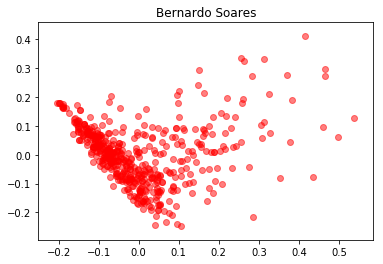

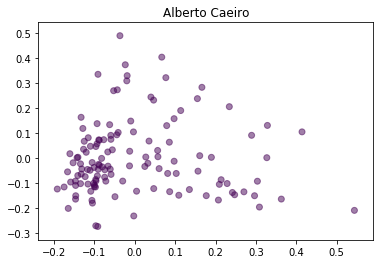

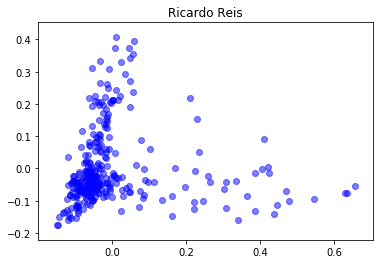

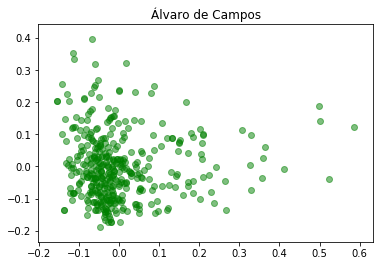

In [39]:
pca = PCA(n_components = 2).fit(bernardo_tfidf.todense())
data2D = pca.transform(bernardo_tfidf.todense())

plt.scatter(data2D[:, 0], data2D[:, 1], c = 'red', alpha = 0.5)
plt.title('Bernardo Soares')
plt.show()

pca = PCA(n_components = 2).fit(alberto_tfidf.todense())
data2D = pca.transform(alberto_tfidf.todense())

plt.scatter(data2D[:, 0], data2D[:, 1], c = alberto.author_encoded, alpha = 0.5)
plt.title('Alberto Caeiro')
plt.show()

pca = PCA(n_components = 2).fit(ricardo_tfidf.todense())
data2D = pca.transform(ricardo_tfidf.todense())

plt.scatter(data2D[:, 0], data2D[:, 1], c = 'b', alpha = 0.5)
plt.title('Ricardo Reis')
plt.show()

pca = PCA(n_components = 2).fit(campos_tfidf.todense())
data2D = pca.transform(campos_tfidf.todense())

plt.scatter(data2D[:, 0], data2D[:, 1], c = 'g', alpha = 0.5)
plt.title('Álvaro de Campos')
plt.show()